# Moving Average Models for Forecasting

The residual errors from forecasts on a time series provide another source of information that we can model. Residual errors themselves form a time series that can have temporal structure. A simple autoregression model of this structure can be used to predict the forecast error, which in turn can be used to correct forecasts. This type of model is called a moving average model, the same name but very different from moving average smoothing.

## Model of Residual Errors
The difference between what was expected and what was predicted is called the residual error, calculated:

- residual_error = expected - predicted

The residual errors from a time series can have temporal structure like trends, bias, and seasonality. Any temporal structure in the time series of residual forecast errors is useful as a diagnostic as it suggests information that could be incorporated into the predictive model. An ideal model would leave no structure in the residual error, just random fluctuations that cannot be modeled.

Structure in the residual error can also be modeled directly. There may be complex signals in the residual error that are di cult to directly incorporate into the model. Instead, you can create a model of the residual error time series and predict the expected error for your model. The predicted error can then be subtracted from the model prediction and in turn provide an additional lift in performance.

A simple and e↵ective model of residual error is an autoregression. This is where some number of lagged error values are used to predict the error at the next time step. These lag errors are combined in a linear regression model, much like an autoregression model of the direct time series observations. An autoregression of the residual error time series is called a Moving Average (MA) model. This is confusing because it has nothing to do with the moving average smoothing process. Think of it as the sibling to the autoregressive (AR) process, except on lagged residual error rather than lagged raw observations.

## Persistence Forecast Model

The simplest forecast that we can make is to forecast that what happened in the previous time step will be the same as what will happen in the next time step. This is called the naive forecast or the persistence forecast model. This model will provide the predictions from which we can calculate the residual error time series. Alternately, we could develop an autoregression model of the time series and use that as our model.

In [11]:
# Calculate residual errors for a presistence forecast model
from pandas import Series
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error
from math import sqrt

#load data
series = Series.from_csv('female-births.csv', header=0)

#create lagged dataset
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis =1)
dataframe.columns = ['t', 't+1']

#split into train and test sets
X = dataframe.values[:-1]
train_size = int(len(X)*0.66)
train, test = X[1:train_size], X[train_size:]
train_x, train_y = train[:, 0], train[:,1]
test_x, test_y = test[:,0], test[:,1]

#persistence model
predictions = [x for x in test_x]

#skill of presistence model
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

#calculate residuals
residuals = [test_y[i] - predictions[i] for i in range(len(predictions))]
residuals = DataFrame(residuals)
print(residuals.head())

Test RMSE: 9.151
      0
0   9.0
1 -10.0
2   3.0
3  -6.0
4  30.0


## Autoregression of Residual Error
We can model the residual error time series using an autoregression model. This is a linear regression model that creates a weighted linear sum of lagged residual error terms.

We can use the autoregression model (AR) provided by the Statsmodels library. Building on the persistence model in the previous section, we can first train the model on the residual errors calculated on the training dataset. This requires that we make persistence predictions for each observation in the training dataset, then create the AR model, as follows.

In [13]:
# Autoregressive model of residual errors
from pandas import Series
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AR

series = Series.from_csv('female-births.csv', header=0)

#create lagged set
values = DataFrame(series.values[:-1])
dataframe = concat([values.shift(1), values], axis = 1)
dataframe.columns = ['t', 't+1']

#split into train/test sets
X = dataframe.values
train_size = int(len(X) * .66)
train, test = X[1:train_size], X[train_size:]
train_x, train_y = train[:,0], train[:,1]
test_x, test_y = test[:,0], test[:,1]

#persistence model on training set
train_pred = [x for x in train_x]

#calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

#model training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
print('Lag=%d, Coef=%s' % (window, coef))

Lag=15, Coef=[ 0.10120699 -0.84940615 -0.77783609 -0.73345006 -0.68902061 -0.59270551
 -0.5376728  -0.42553356 -0.24861246 -0.19972102 -0.15954013 -0.11045476
 -0.14045572 -0.13299964 -0.12515801 -0.03615774]


Next, we can step through the test dataset and for each time step we must: 
1. Calculate the persistence prediction (t+1 = t).
2. Predict the residual error using the autoregression model.

The autoregression model requires the residual error of the 15 previous time steps. Therefore, we must keep these values handy. As we step through the test dataset timestep by timestep making predictions and estimating error, we can then calculate the actual residual error and update the residual error time series lag values (history) so that we can calculate the error at the next time step.
This is a walk forward forecast, or a rolling forecast, model. We end up with a time series of the residual forecast error from the train dataset and a predicted residual error on the test dataset. We can plot these and get a quick idea of how skillful the model is at predicting residual error.

Populating the interactive namespace from numpy and matplotlib


/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


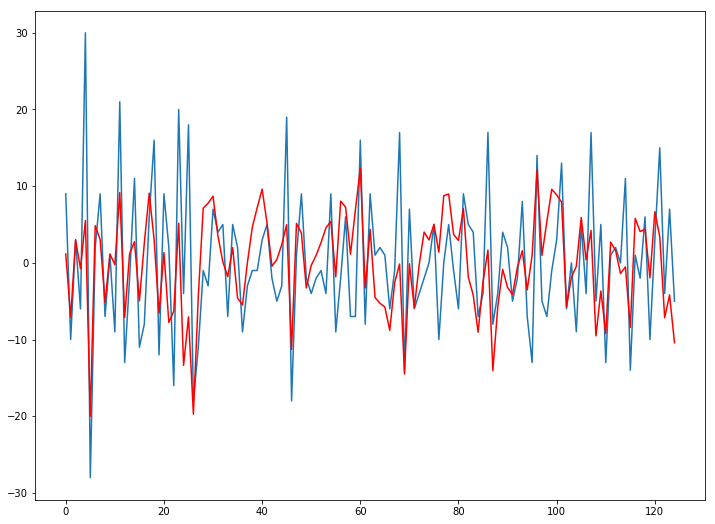

In [19]:
# Autoregressive model of residual errors
%pylab inline
pylab.rcParams['figure.figsize'] = (12,9)
from pandas import Series
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AR
from matplotlib import pyplot

series = Series.from_csv('female-births.csv', header=0)

#create lagged set
values = DataFrame(series.values[:-1])
dataframe = concat([values.shift(1), values], axis = 1)
dataframe.columns = ['t', 't+1']

#split into train/test sets
X = dataframe.values
train_size = int(len(X) * .66)
train, test = X[1:train_size], X[train_size:]
train_x, train_y = train[:,0], train[:,1]
test_x, test_y = test[:,0], test[:,1]

#persistence model on training set
train_pred = [x for x in train_x]

#calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

#model training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

#walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()
for t in range(len(test_y)):
    #persistence
    yhat = test_x[t]
    error = test_y[t] - yhat
    expected_error.append(error)
    #predict error
    length = len(history)
    lag = len(history)
    lag = [history[i] for i in range(length-window, length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    predictions.append(pred_error)
    history.append(error)
    #print('predicted error=%f, expected error=%f' % (pred_error, error))
    
#plot predicted error
pyplot.plot(expected_error)
pyplot.plot(predictions, color='red')
pyplot.show()

## Correct Predictions with a Model of Residuals

A model of forecast residual error is interesting, but it can also be useful to make better predictions. With a good estimate of forecast error at a time step, we can make better predictions. For example, we can add the expected forecast error to a prediction to correct it and in turn improve the skill of the model.

- improved_forcast = forecast + estimated_error

Test RMSE: 7.499


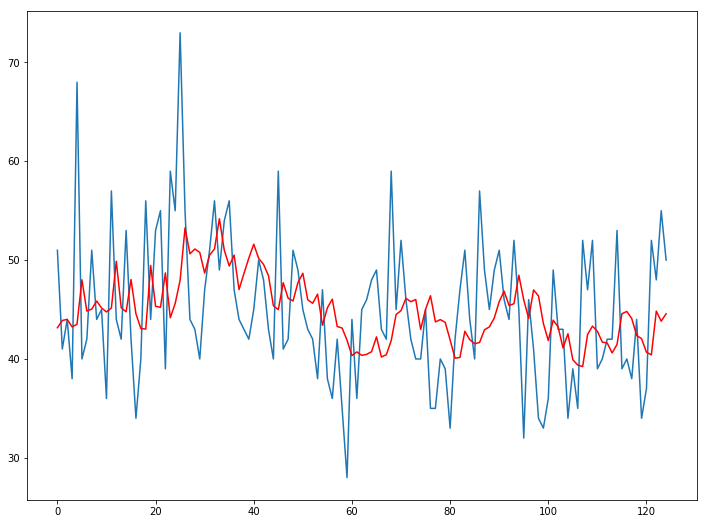

In [23]:
# Correct forecasts with a model of forecast residual errors
from pandas import Series
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AR
from matplotlib import pyplot

series = Series.from_csv('female-births.csv', header=0)

#create lagged set
values = DataFrame(series.values[:-1])
dataframe = concat([values.shift(1), values], axis = 1)
dataframe.columns = ['t', 't+1']

#split into train/test sets
X = dataframe.values
train_size = int(len(X) * .66)
train, test = X[1:train_size], X[train_size:]
train_x, train_y = train[:,0], train[:,1]
test_x, test_y = test[:,0], test[:,1]

#persistence model on training set
train_pred = [x for x in train_x]

#calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]

#model training set residuals
model = AR(train_resid)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

#walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
expected_error = list()
for t in range(len(test_y)):
    #persistence
    yhat = test_x[t]
    error = test_y[t] - yhat
    #predict error
    length = len(history)
    lag = len(history)
    lag = [history[i] for i in range(length-window, length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    #correct the prediction
    yhat = yhat + pred_error
    predictions.append(yhat)
    history.append(error)
    #print('predicted error=%f, expected=%f' % (yhat, test_y[t]))
    
#error
rmse = sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' % rmse)

#plot predicted error
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

Running the example prints the predictions and the expected outcome for each time step in the test dataset. The RMSE of the corrected forecasts is calculated to be 7.499 births per day, which is much better than the score of 9.151 for the persistence model alone.

Finally, the expected values for the test dataset are plotted compared to the corrected forecast. We can see that the persistence model has been aggressively corrected back to a time series that looks something like a moving average.